In [17]:

import cv2
import matplotlib.pyplot as plt
import os
import pandas as pd
import numpy as np
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split

In [18]:
#download the data set from kaggle - https://www.kaggle.com/datasets/navoneel/brain-mri-images-for-brain-tumor-detection

yes_files = os.listdir(os.path.join("brain_tumor_dataset","yes"))
no_files = os.listdir(os.path.join("brain_tumor_dataset","no"))
img_path = "brain_tumor_dataset"

yes_files = [os.path.join("yes",yes_files[i]) for i in range(len(yes_files))]
no_files = [os.path.join("no",no_files[i]) for i in range(len(no_files))]

df = pd.DataFrame({
    "filename" : yes_files,
    "label" : "yes"
})

df2 = pd.DataFrame({
    "filename" : no_files,
    "label" : "no" 
})

df = pd.concat([df, df2])

df

,filename,label
0,yes\Y1.jpg,yes
1,yes\Y10.jpg,yes
2,yes\Y100.JPG,yes
3,yes\Y101.jpg,yes
4,yes\Y102.jpg,yes
...,...,...
93,no\No18.jpg,no
94,no\No19.jpg,no
95,no\No20.jpg,no
96,no\No21.jpg,no


In [19]:
df.describe()

,filename,label
count,253,253
unique,253,2
top,yes\Y1.jpg,yes
freq,1,155


In [20]:
grouped_data = df.groupby("label")
grouped_data.describe()


filename                          
         count unique           top freq
label                                   
no          98     98  no\1 no.jpeg    1
yes        155    155    yes\Y1.jpg    1

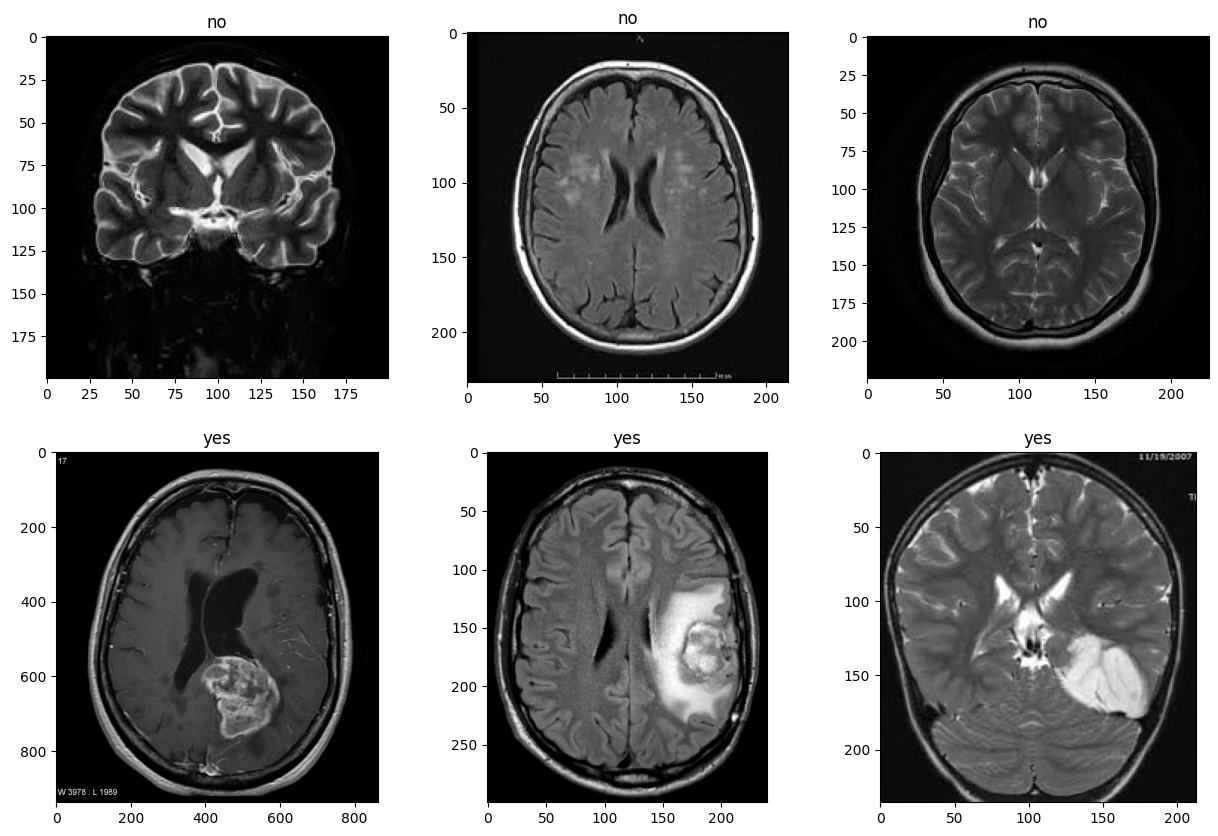

In [21]:
import random

fig, axis = plt.subplots(len(grouped_data), 3, figsize=(15,10))

for i,(category,dataframe) in enumerate(grouped_data):
    rand_nums = random.sample(range(len(dataframe)), 3)
    for j,index in enumerate(rand_nums):
        filename = os.path.join(img_path, dataframe.iloc[index]["filename"])
        img = cv2.imread(filename)
        axis[i, j].imshow(img)
        axis[i, j].set_title(category)
        

In [22]:
wids = []
heights = []

for (category,dataframe) in grouped_data:
    for name in dataframe["filename"]:
        img = cv2.imread(os.path.join(img_path, name))
        (h, w, _) = img.shape
        heights.append(h)
        wids.append(w)

print(f"Median Value : {np.median(heights)} X {np.median(wids)}")

Median Value : 331.0 X 278.0


In [23]:
labels = df["label"]

x_train,x_test = train_test_split(df, stratify=labels, test_size=0.2)

print(x_train.shape)
print(x_test.shape)


test_labels = x_test["label"]
x_val, x_test = train_test_split(x_test, stratify=test_labels, test_size=0.5)
print(x_val.shape)
print(x_test.shape)


(202, 2)
(51, 2)
(25, 2)
(26, 2)


In [24]:
data_gen = ImageDataGenerator(rescale=(1./255))
batch_size = 32
image_height = 270
image_width = 270

In [25]:
train_gen = data_gen.flow_from_dataframe(x_train,
                                         directory=img_path,
                                         x_col="filename",
                                         y_col="label",
                                         class_mode='binary',
                                         classes=["yes","no"],
                                         target_size=(image_height,image_width),
                                         batch_size=batch_size)

Found 202 validated image filenames belonging to 2 classes.


In [26]:
test_gen = data_gen.flow_from_dataframe(x_test,
                                        directory=img_path,
                                        x_col="filename",
                                        y_col="label",
                                        class_mode='binary',
                                        classes=["yes","no"],
                                        target_size=(image_height,image_width),
                                        batch_size=batch_size)

Found 26 validated image filenames belonging to 2 classes.


In [27]:
for batch in test_gen:
    batch_shape = batch[0].shape  # Shape of the batch (batch_size, height, width, channels)
    print("Batch shape:", batch_shape)
    
    # Stop the loop when all batches have been processed
    if test_gen.batch_index == 0:
        break

Batch shape: (26, 270, 270, 3)


In [28]:
val_gen = data_gen.flow_from_dataframe(x_val,
                                        directory=img_path,
                                        x_col="filename",
                                        y_col="label",
                                        classes=["yes","no"],
                                        class_mode='binary',
                                        target_size=(image_height,image_width),
                                        batch_size=batch_size)

Found 25 validated image filenames belonging to 2 classes.


In [29]:
from keras.models import Sequential,load_model
from keras.layers import Conv2D, MaxPooling2D,Flatten,Dense
from keras.callbacks import EarlyStopping,ModelCheckpoint

model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(image_width, image_height, 3)))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])



In [30]:
es = EarlyStopping(
    monitor="val_acc",
    patience=10,
    verbose=1,
    mode="max",
    restore_best_weights=True,
)

model_ckpt = ModelCheckpoint("BrainTumor",
                            monitor="val_loss",
                            save_best_only=True)

In [31]:
# from keras.utils import plot_model
# plot_model(model,show_shapes=True, )


In [32]:
history = model.fit(train_gen,
                    batch_size=batch_size,
                    validation_data=val_gen,
                    callbacks=[model_ckpt, es],
                    epochs=10)

Epoch 1/5
7/7 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 0.5743

INFO:tensorflow:Assets written to: BrainTumor\assets


INFO:tensorflow:Assets written to: BrainTumor\assets


7/7 [==============================] - 20s 2s/step - loss: 0.0000e+00 - accuracy: 0.5743 - val_loss: 0.0000e+00 - val_accuracy: 0.6000
Epoch 2/5
7/7 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 0.6139WARNING:tensorflow:Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy


7/7 [==============================] - 3s 413ms/step - loss: 0.0000e+00 - accuracy: 0.6139 - val_loss: 0.0000e+00 - val_accuracy: 0.6000
Epoch 3/5
7/7 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 0.6139WARNING:tensorflow:Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy


7/7 [==============================] - 3s 417ms/step - loss: 0.0000e+00 - accuracy: 0.6139 - val_loss: 0.0000e+00 - val_accuracy: 0.6000
Epoch 4/5
7/7 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 0.6139WARNING:tensorflow:Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy


7/7 [==============================] - 3s 466ms/step - loss: 0.0000e+00 - accuracy: 0.6139 - val_loss: 0.0000e+00 - val_accuracy: 0.6000
Epoch 5/5
7/7 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 0.6139WARNING:tensorflow:Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy


7/7 [==============================] - 3s 418ms/step - loss: 0.0000e+00 - accuracy: 0.6139 - val_loss: 0.0000e+00 - val_accuracy: 0.6000


In [33]:

brain_tumor = load_model("BrainTumor")
result = brain_tumor.predict(test_gen)

result_argmax = np.argmax(result, axis=1)

y_true = test_gen.labels

y_pred = result_argmax

accuracy = (y_pred == y_true).mean()

print("Test Accuracy:", accuracy)

1/1 [==============================] - 3s 3s/step
Test Accuracy: 0.6153846153846154


In [34]:
from sklearn.metrics import confusion_matrix,classification_report
cm=confusion_matrix(y_true = test_gen.classes,y_pred = np.argmax(result, axis =1))
print(cm)

[[16  0]
 [10  0]]


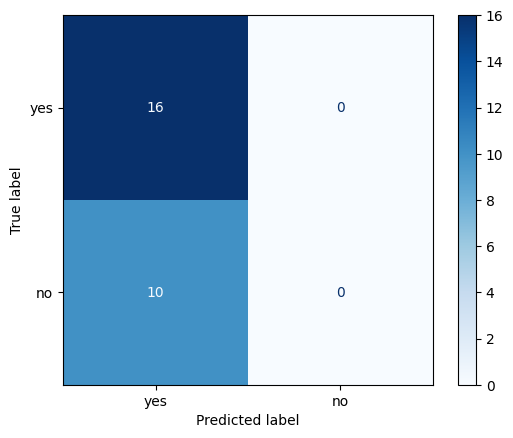

In [35]:
from sklearn.metrics import ConfusionMatrixDisplay

labels = ['yes','no']
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)

disp.plot(cmap=plt.cm.Blues)
plt.show()